<a href="https://colab.research.google.com/github/gabrielfea/CMAPSSData/blob/main/Estudo_base_04_OK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tabulate -q -U
!pip install seaborn -q -U
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Layer, MultiHeadAttention, Dropout, LayerNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tabulate import tabulate
import random
import seaborn as sns

# Inicializar a TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default strategy that works on CPU and single GPU
    print('Running on ', 'CPU or GPU')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.3 MB/s eta 0:00:00
Running on TPU  


Epoch 1/250
457/457 [==============================] - 57s 68ms/step - loss: 982.0323 - val_loss: 243.8963
Epoch 2/250
457/457 [==============================] - 16s 35ms/step - loss: 200.6495 - val_loss: 155.4098
Epoch 3/250
457/457 [==============================] - 16s 35ms/step - loss: 131.5003 - val_loss: 78.8857
Epoch 4/250
457/457 [==============================] - 16s 35ms/step - loss: 115.0738 - val_loss: 166.9256
Epoch 5/250
457/457 [==============================] - 16s 34ms/step - loss: 305.5123 - val_loss: 901.5906
Epoch 6/250
457/457 [==============================] - 16s 35ms/step - loss: 812.5002 - val_loss: 792.7505
Epoch 7/250
457/457 [==============================] - 16s 34ms/step - loss: 812.5016 - val_loss: 777.1600
Epoch 8/250
457/457 [==============================] - 16s 35ms/step - loss: 813.5934 - val_loss: 778.2661
Epoch 9/250
457/457 [==============================] - 16s 35ms/step - loss: 816.6690 - val_loss: 830.0982
Epoch 10/250
457/457 [================

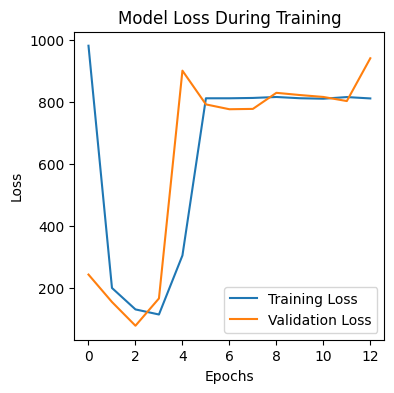

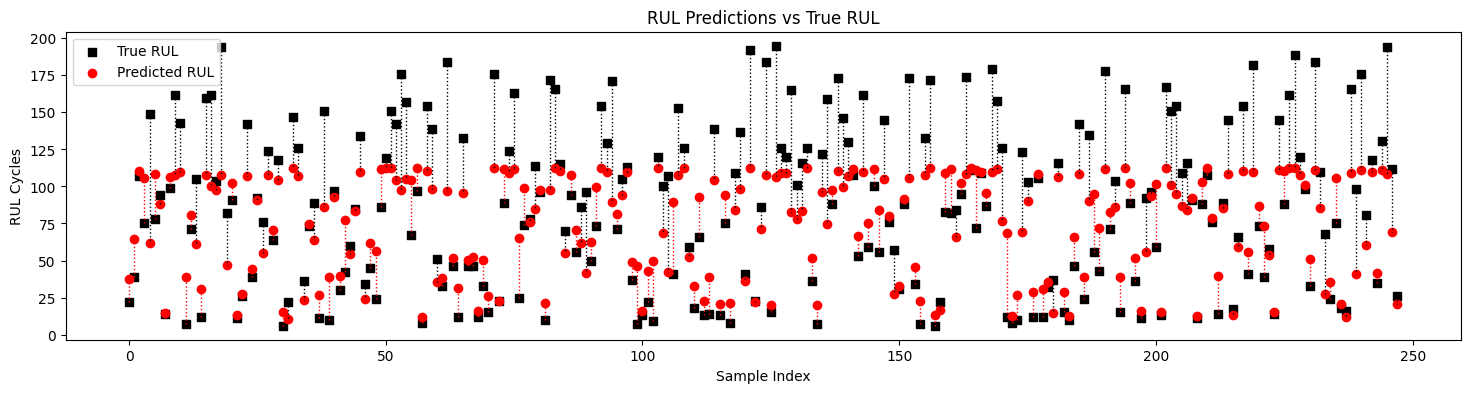

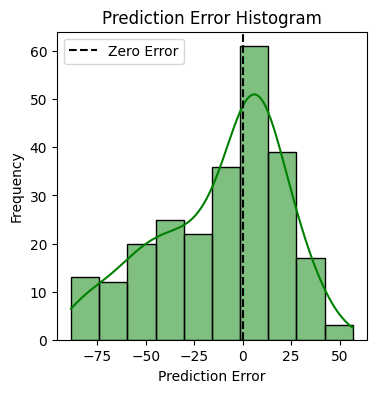

In [4]:
# Função para carregar os dados
def load_data(file_path):
    data = pd.read_csv(file_path, sep=' ', header=None)
    data.dropna(axis=1, how='all', inplace=True)
    return data.values

#Features Selection
features_selection =[x for x in range(2,26)] #[x+5-1 for x in [4,7,11,12,15,17,20,21]]

# Função para preparar os dados de treinamento
def prepare_train_data(data, sequence_length):
    X, y = [], []
    for unit in np.unique(data[:, 0]):
        unit_data = data[data[:, 0] == unit]
        for i in range(len(unit_data) - sequence_length + 1):
            X.append(unit_data[i:i+sequence_length, features_selection])
            y.append(min(len(unit_data) - i - sequence_length, 127))
    return np.array(X), np.array(y)

# Função para preparar os dados de teste
def prepare_test_data(data, sequence_length):
    X = []
    for unit in np.unique(data[:, 0]):
        unit_data = data[data[:, 0] == unit]
        if len(unit_data) >= sequence_length:
            X.append(unit_data[-sequence_length:, features_selection])
        else:
            pad_size = sequence_length - len(unit_data)
            padded_data = np.pad(unit_data[:, features_selection], ((pad_size, 0), (0, 0)), 'constant')
            X.append(padded_data)
    return np.array(X)

# Função de cálculo Score
def custom_score(y_true, y_pred):
    """
    Calculate the custom score based on the provided formula.

    Parameters:
    y_true (tensor): Ground truth values.
    y_pred (tensor): Predicted values.

    Returns:
    tensor: Calculated score.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    d = y_pred - y_true
    mask_negative = tf.less(d, 0.0)
    mask_positive = tf.greater_equal(d, 0.0)

    score_negative = tf.exp(-d / 13) - 1
    score_positive = tf.exp(d / 10) - 1

    score = tf.zeros_like(d)
    score += tf.where(mask_negative, score_negative, tf.zeros_like(d))
    score += tf.where(mask_positive, score_positive, tf.zeros_like(d))

    return tf.reduce_sum(score)

# Transformer Encoder Layer
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Transformer Decoder Layer
class TransformerDecoderBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerDecoderBlock, self).__init__()
        self.att1 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)

    def call(self, inputs, enc_output, training, look_ahead_mask=None, padding_mask=None):
        attn1, attn_weights_block1 = self.att1(
            inputs, inputs, attention_mask=look_ahead_mask, return_attention_scores=True
        )
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(inputs + attn1)

        attn2, attn_weights_block2 = self.att2(
            out1, enc_output, attention_mask=padding_mask, return_attention_scores=True
        )
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)

        return out3, attn_weights_block1, attn_weights_block2

# Função para construir o Encoder
class TransformerEncoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, inputs, training):
        x = inputs
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training)
        return self.dropout(x, training=training)

# Função para construir o Decoder
class TransformerDecoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerDecoder, self).__init__()
        self.num_layers = num_layers
        self.dec_layers = [TransformerDecoderBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, inputs, enc_output, training, look_ahead_mask=None, padding_mask=None):
        attention_weights = {}
        x = inputs
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
        return self.dropout(x, training=training), attention_weights

# Função para construir o modelo
def build_model(input_shape, num_layers=2, embed_dim=100, num_heads=2, ff_dim=100, rate=0.1):
    inputs = Input(shape=input_shape)



    # CNN
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding="same", strides=1)(x)


    # LSTM
    x = LSTM(embed_dim, return_sequences=True)(inputs)
    x = LSTM(embed_dim, return_sequences=True)(x)  # Retain sequences for Transformer input

    # Transformer Encoder
    encoder = TransformerEncoder(num_layers=num_layers, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, rate=rate)
    x = encoder(x)

    # Transformer Decoder
    decoder = TransformerDecoder(num_layers=num_layers, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, rate=rate)
    x, attention_weights = decoder(x, x)  # Self attention, so enc_output is the same as input

    # Flatten and Dense
    x = Flatten()(x)
    outputs = Dense(1)(x)

    # Configurar a learning rate desejada
    learning_rate = 0.001
    optimizer = Adam(learning_rate=learning_rate)

    model = Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss=custom_score)
    return model

# Função para calcular as métricas
def evaluate_model(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)

    metrics = {
        'Metric': ['R²', 'MAPE', 'MAE', 'MSE', 'RMSE', "Score"],
        'Value': [
            r2_score(y_true, y_pred),
            mean_absolute_percentage_error(y_true, y_pred),
            mean_absolute_error(y_true, y_pred),
            mean_squared_error(y_true, y_pred),
            np.sqrt(mean_squared_error(y_true, y_pred)),
            custom_score(y_true, y_pred).numpy()  # Certifique-se de que o custom_score retorna um valor numérico
        ]
    }

    df_metrics = pd.DataFrame(metrics)
    print(tabulate(df_metrics, headers='keys', tablefmt='pretty'))

# Função para plotar o histórico de treinamento
def plot_training_history(history):
    plt.figure(figsize=(4, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Função para plotar as previsões de RUL como scatter plot com linhas ajustadas
def plot_rul_predictions(y_true, y_pred):
    plt.figure(figsize=(18, 4))  # Aumentar a largura do gráfico
    indices = np.arange(len(y_true))

    plt.scatter(indices, y_true, label='True RUL', color='black', marker='s')
    plt.scatter(indices, y_pred, label='Predicted RUL', color='red', marker='o')

    # Adicionar linhas finas pretas entre previsões e valores reais
    for i in range(len(y_true)):
        if y_pred[i] < y_true[i]:
            plt.plot([i, i], [y_true[i], y_pred[i]], color='black', linewidth=1, linestyle=":")
        else:
            plt.plot([i, i], [y_true[i], y_pred[i]], color='red', linewidth=1, linestyle=":")

    plt.title('RUL Predictions vs True RUL')
    plt.xlabel('Sample Index')
    plt.ylabel('RUL Cycles')
    plt.legend()
    plt.show()

# Função para plotar o histograma de erro de previsão do RUL
def plot_rul_error_histogram(y_true, y_pred):
    errors = y_pred - y_true
    plt.figure(figsize=(4,4))
    sns.histplot(errors, kde=True, color="green", bins=10)
    plt.axvline(x=0, color='k', linestyle='--', label='Zero Error')
    plt.title('Prediction Error Histogram')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Definindo a semente aleatória para TensorFlow e NumPy
os.environ['PYTHONHASHSEED'] = str(18)
tf.random.set_seed(18)
np.random.seed(18)
random.seed(18)

# Configuração para garantir reprodutibilidade em TensorFlow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Defina o caminho correto para os dados no Google Drive
data_path = 'drive/MyDrive/CMAPSSData/'

# Carregar dados
data_train = load_data(data_path + 'train_FD004.txt')
data_test = load_data(data_path + 'test_FD004.txt')
data_rul = load_data(data_path + 'RUL_FD004.txt').flatten()

# Escalar dados
scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

# Preparar dados
sequence_length = 75
X_train, y_train = prepare_train_data(data_train, sequence_length)
X_test = prepare_test_data(data_test, sequence_length)

# Construir modelo
input_shape = (X_train.shape[1], X_train.shape[2])

with strategy.scope():
    model = build_model(input_shape)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinar modelo
history = model.fit(X_train, y_train, epochs=250, batch_size=75, validation_split=0.2, callbacks=[early_stopping])

# Fazer previsões
y_pred = model.predict(X_test).flatten()

# Avaliar modelo
evaluate_model(data_rul, y_pred)

# Plotar histórico de treinamento
plot_training_history(history)

# Plotar previsões de RUL
plot_rul_predictions(data_rul, y_pred)

# Plotar histograma de erro de previsão do RUL
plot_rul_error_histogram(data_rul, y_pred)
